In [1]:
# Module Import and Settings

import os
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from autoimpute.imputations import SingleImputer

from scipy.stats.mstats import winsorize

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from factor_analyzer import FactorAnalyzer

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
from sklearn.metrics import silhouette_score


pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 2000)
sns.set()

dst = r"C:\Users\Aakash\Documents\hospital\flatfiles"
img_dst = r"C:\Users\Aakash\Documents\hospital\images"

if not os.path.exists(img_dst):
    os.mkdir(img_dst)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Aakash\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Data import 

def read_from_dst(file_name):
    try:
        return pd.read_csv(f"{dst}\{file_name}.csv")
    except UnicodeDecodeError:
        return pd.read_csv(f"{dst}\{file_name}.csv", encoding = 'latin')
    
complications = read_from_dst("complications - Hospital")
hcahps = read_from_dst("HCAHPS - Hospital")
infections = read_from_dst("Healthcare Associated Infections - Hospital")
info = read_from_dst("Hospital General Information")
imaging = read_from_dst("Outpatient Imaging Efficiency - Hospital")
reAdm_deaths = read_from_dst("Readmissions and Deaths - Hospital")
tne = read_from_dst("Timely and Effective Care - Hospital")
combined = [info, complications, hcahps, infections, imaging, reAdm_deaths, tne]

# standardizing column names
for df in combined:
    df.columns = [col.lower().strip().replace(' ',  '_') for col in df.columns]

In [3]:
for df in combined:
    display(df.head(2))

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,hospital_type,hospital_ownership,emergency_services,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating,hospital_overall_rating_footnote,mortality_national_comparison,mortality_national_comparison_footnote,safety_of_care_national_comparison,safety_of_care_national_comparison_footnote,readmission_national_comparison,readmission_national_comparison_footnote,patient_experience_national_comparison,patient_experience_national_comparison_footnote,effectiveness_of_care_national_comparison,effectiveness_of_care_national_comparison_footnote,timeliness_of_care_national_comparison,timeliness_of_care_national_comparison_footnote,efficient_use_of_medical_imaging_national_comparison,efficient_use_of_medical_imaging_national_comparison_footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN


,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,measure_name,measure_id,compared_to_national,denominator,score,lower_estimate,higher_estimate,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of complications for hip/knee replacement...,COMP_HIP_KNEE,No Different than the National Rate,331,3.8,2.6,5.5,NaN,04/01/2012,03/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Serious blood clots after surgery,PSI_12_POSTOP_PULMEMB_DVT,No Different than the National Rate,4549,3.32,1.25,5.38,NaN,07/01/2013,06/30/2015


,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,hcahps_measure_id,hcahps_question,hcahps_answer_description,patient_survey_star_rating,patient_survey_star_rating_footnote,hcahps_answer_percent,hcahps_answer_percent_footnote,hcahps_linear_mean_value,number_of_completed_surveys,number_of_completed_surveys_footnote,survey_response_rate_percent,survey_response_rate_percent_footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_STAR_RATING,Summary star rating,Summary star rating,3,NaN,Not Applicable,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_A_P,Patients who reported that their room and bath...,"Room was ""always"" clean",Not Applicable,NaN,66,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015


,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,measure_name,measure_id,compared_to_national,score,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Lower Confidence Limit,HAI_1_CI_LOWER,NaN,1.03,NaN,1/1/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Upper Confidence Limit,HAI_1_CI_UPPER,NaN,2.765,NaN,1/1/2015,12/31/2015


,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,measure_id,measure_name,score,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_10,Abdomen CT Use of Contrast Material,6.4,NaN,07/01/2014,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,OP_11,Thorax CT Use of Contrast Material,0.9,NaN,07/01/2014,06/30/2015


,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,measure_name,measure_id,compared_to_national,denominator,score,lower_estimate,higher_estimate,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015


,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,condition,measure_id,measure_name,score,sample,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_7a,Fibrinolytic Therapy Received Within 30 Minute...,Not Available,Not Available,7 - No cases met the criteria for this measure.,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart Attack or Chest Pain,AMI_8a,Primary PCI Received Within 90 Minutes of Hosp...,92,24,3 - Results are based on a shorter time period...,01/01/2015,09/30/2015


In [4]:
# to check if inconsistencies exist with provider_id
for df in combined:
    print(df.provider_id.value_counts().nunique())
    print(df.provider_id.value_counts().unique())
    
# converting target variable to numeric
info.hospital_overall_rating = pd.to_numeric(info.hospital_overall_rating, errors='coerce')

1
[1]
1
[11]
1
[55]
1
[48]
1
[6]
1
[14]
1
[43]


## Data Cleaning

In [5]:
# making a filter list

drop_list = info.columns[1:8].copy() # common columns to drop

all_columns = []
filter_list = []
for frame in combined:
    for col in frame.columns:
        all_columns.append(col)
        
all_columns = set(all_columns) # All Unique columns

# dropping repeating offenders and common columns
for x in all_columns:
    if 'footnote' not in x:
        if 'start_date' not in x:
            if 'end_date' not in x:
                filter_list.append(x)
        
for x in drop_list:
    filter_list.remove(x)
    
# Manually eliminating rest of the columns
manual_elim = ['measure_name', 'condition']

for x in manual_elim:
    filter_list.remove(x)
    

# mapping variables
nat_avg = {'Not Available': np.nan, 'Below the National average': 0, 
           'Same as the National average': 1, 'Above the National average': 2}

nat_compare = {'Worse than the National Rate': 0, 'No Different than the National Rate': 1,
              'Better than the National Rate': 2, 'Number of Cases Too Small': np.nan}

nat_compare_2 = {'Worse than the National Benchmark': 0, 'No Different than National Benchmark': 1, 
                 'Better than the National Benchmark': 2}

for mapper in [nat_compare, nat_avg, nat_compare_2]:
    info = info.applymap(lambda x: mapper[x] if x in mapper.keys() else x)   
    complications = complications.applymap(lambda x: mapper[x] if x in mapper.keys() else x)
    hcahps = hcahps.applymap(lambda x: mapper[x] if x in mapper.keys() else x)
    infections = infections.applymap(lambda x: mapper[x] if x in mapper.keys() else x)
    imaging = imaging.applymap(lambda x: mapper[x] if x in mapper.keys() else x)
    reAdm_deaths = reAdm_deaths.applymap(lambda x: mapper[x] if x in mapper.keys() else x)
    tne = tne.applymap(lambda x: mapper[x] if x in mapper.keys() else x)

# EDA

In [6]:
# Useful functions for visualization
def plot_categorical(cat, df, df_name='df'):
    temp = df[cat].value_counts()

    sns.barplot(temp.values, temp.index, orient='h')
    plt.title(cat)
    plt.xlabel('frequency')
    plt.savefig(f"{img_dst}\{df_name}_{cat}.jpg", bbox_inches='tight', dpi=300)
    plt.show()
    

### Information

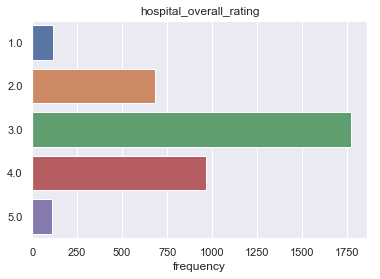

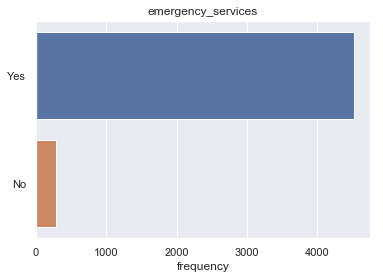

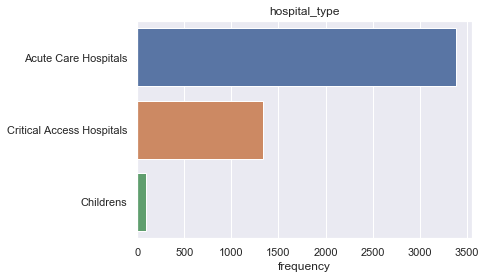

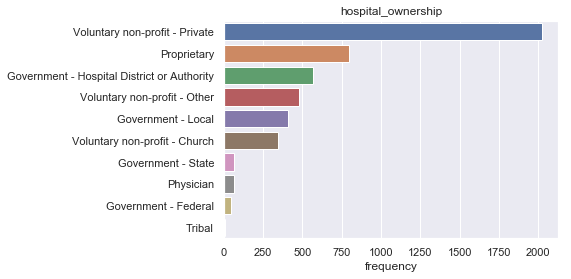

In [7]:
# Frequency overall ratings
plot_categorical('hospital_overall_rating', info, 'info')
plot_categorical('emergency_services', info, 'info')
plot_categorical('hospital_type', info, 'info')
plot_categorical('hospital_ownership', info, 'info')

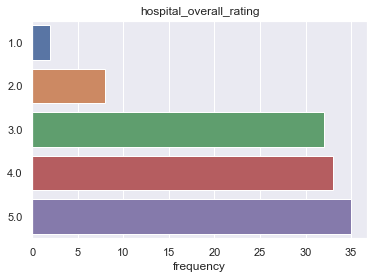

In [8]:
A = info[info.emergency_services == 'No']
plot_categorical('hospital_overall_rating', A, 'no_emergency')

### Complications

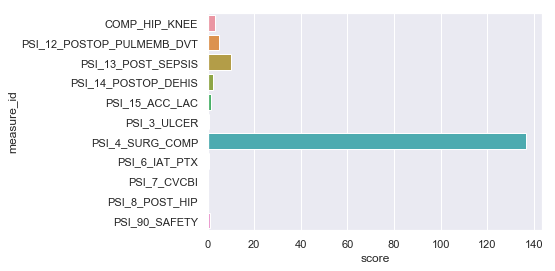

,measure_name,measure_id
0,Rate of complications for hip/knee replacement...,COMP_HIP_KNEE
1,Serious blood clots after surgery,PSI_12_POSTOP_PULMEMB_DVT
2,Blood stream infection after surgery,PSI_13_POST_SEPSIS
3,A wound that splits open after surgery on the...,PSI_14_POSTOP_DEHIS
4,Accidental cuts and tears from medical treatment,PSI_15_ACC_LAC
5,Pressure sores,PSI_3_ULCER
6,Deaths among Patients with Serious Treatable C...,PSI_4_SURG_COMP
7,Collapsed lung due to medical treatment,PSI_6_IAT_PTX
8,Infections from a large venous catheter,PSI_7_CVCBI
9,Broken hip from a fall after surgery,PSI_8_POST_HIP


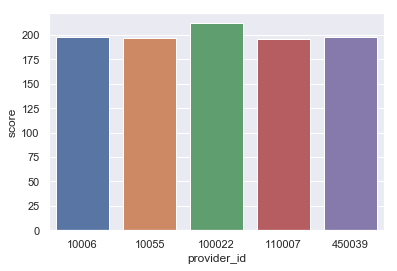

In [9]:
complications.head(2)
complications['score'] = complications['score'].astype(float)
complications['provider_id'] = complications['provider_id'].astype('O')

# Comparing weightage given to different measures
temp = complications.groupby('measure_id', as_index=False).agg({'score': 'mean'})
sns.barplot(temp.score, temp.measure_id, orient='h')
plt.show()

# Unique Measures
display(complications[['measure_name', 'measure_id']].drop_duplicates())

# top 5 providers with highest scores for measure 'PSI_4_SURG_COMP'
temp = complications[complications.measure_id == 'PSI_4_SURG_COMP'].sort_values('score', ascending=False).head(5)
sns.barplot(temp.provider_id, temp.score)
plt.show()

We can see that from all the measures the weightage for Surgery measure is a lot greater than others. Hospitals with higher score in this measure will have a significant edge.

### Readmissions and Deaths

,measure_name,measure_id
0,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI
1,Death rate for CABG,MORT_30_CABG
2,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD
3,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF
4,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN
5,Death rate for stroke patients,MORT_30_STK
6,Acute Myocardial Infarction (AMI) 30-Day Readm...,READM_30_AMI
7,Rate of readmission for CABG,READM_30_CABG
8,Rate of readmission for chronic obstructive pu...,READM_30_COPD
9,Heart failure (HF) 30-Day Readmission Rate,READM_30_HF


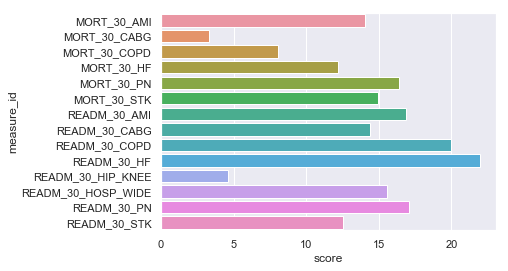

In [10]:
# Unique Measures
display(reAdm_deaths[['measure_name', 'measure_id']].drop_duplicates())

reAdm_deaths['score'] = reAdm_deaths['score'].astype(float)

# Weightage of each measure
temp = reAdm_deaths.groupby('measure_id', as_index=False).agg({'score': 'mean'})
sns.barplot(temp.score, temp.measure_id, orient='h')
plt.show()

Compared to `complications`, the weightage of measures in `readmissions & deaths` is more balanced. the important measures include:

* READM_30_HF
* READM_30_COPD
* READM_30_PN
* READM_30_AMI
* MORT_30_PN

There seems to be a higher emphasis on frequency and quality of Readmissions compared to measures involving mortality.

### Imaging

,measure_name,measure_id
0,Abdomen CT Use of Contrast Material,OP_10
1,Thorax CT Use of Contrast Material,OP_11
2,Outpatients who got cardiac imaging stress tes...,OP_13
3,Outpatients with brain CT scans who got a sinu...,OP_14
4,MRI Lumbar Spine for Low Back Pain,OP_8
5,Mammography Follow-up Rates,OP_9


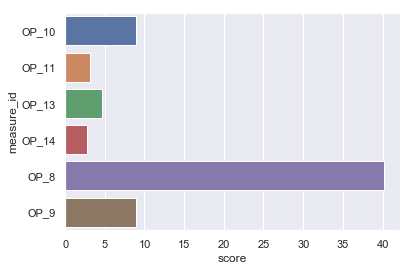

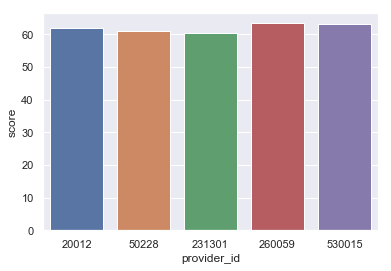

In [11]:
# Unique Measures
display(imaging[['measure_name', 'measure_id']].drop_duplicates())

# Comparing weightage of measures
imaging['score'] = imaging['score'].astype(float)
temp = imaging.groupby('measure_id', as_index=False).agg({'score': 'mean'})
sns.barplot(temp.score, temp.measure_id, orient='h')
plt.show()

# top 5 providers with highest scores for measure 'OP_8'
temp = imaging[imaging.measure_id == 'OP_8'].sort_values('score', ascending=False).head(5)
sns.barplot(temp.provider_id, temp.score)
plt.show()

Measure `OP_8` (MRI Lumbar Spine for Low Back Pain) is much more significant than the rest of the measures. Average score for top 5 providers of this measure is 60.

### Timely and Effectiveness

,measure_name,measure_id
0,Fibrinolytic Therapy Received Within 30 Minute...,AMI_7a
1,Primary PCI Received Within 90 Minutes of Hosp...,AMI_8a
2,Home Management Plan of Care Document,CAC_3
3,ED1,ED_1b
4,ED2,ED_2b
5,Emergency department volume,EDV
6,Evaluation of LVS Function,HF_2
7,Immunization for influenza,IMM_2
8,Healthcare workers given influenza vaccination,IMM_3_OP_27_FAC_ADHPCT
9,Median Time to Fibrinolysis,OP_1


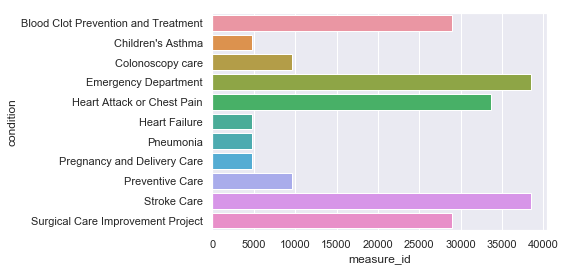

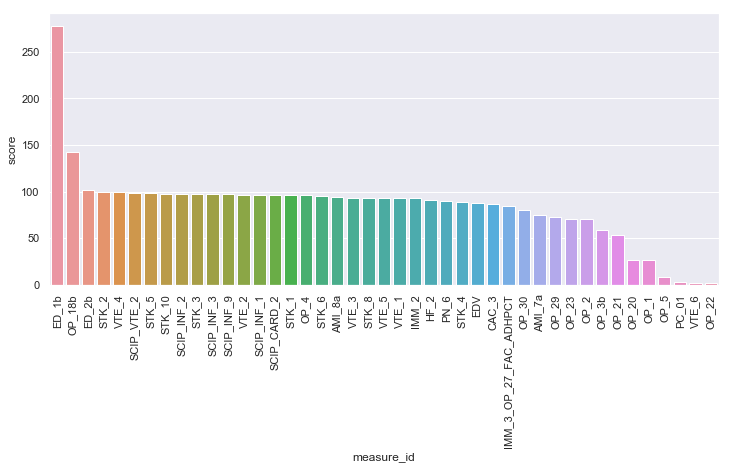

In [12]:
# Unique Measures
display(tne[['measure_name', 'measure_id']].drop_duplicates())

# number of measures for each condition
temp = tne.groupby('condition', as_index=False).agg({'measure_id': 'count'})
sns.barplot(temp.measure_id, temp.condition, orient='h')
plt.show()

low = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.25)
medium = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.5)
high = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.75)
v_high = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.9)

score_map = {'Low (0 - 19,999 patients annually)': low, 'Medium (20,000 - 39,999 patients annually)': medium,
             'High (40,000 - 59,999 patients annually)': high, 'Very High (60,000+ patients annually)': v_high}

tne.score = tne.score.map(score_map).fillna(tne.score)
tne.score = pd.to_numeric(tne.score, 'coerce')
temp = tne.groupby('measure_id', as_index=False).agg({'score': 'mean'}).sort_values('score', ascending=False)
plt.figure(figsize=(12, 5))
sns.barplot(temp.measure_id, temp.score, orient='v')
plt.xticks(rotation=90)
plt.show()

We can observe that the number of measures across specified conditions is highest for `Stroke Care`, `Emergency Department` and `Heart Attack`. This can either mean that more importance is given to these conditions or more number of hospitals have services available for these conditions. The former can be confirmed by comparing weightages between measures.

Highest average score is given to measure `ED_1b` which is part of `Emergency Department`. This confirms which conditions are being focussed towards by Medicare/Medicaid.

## Cleaning the dataframes

In [13]:
# Cleaning info df
info = info[info.columns.intersection(filter_list)]

dummies = info.select_dtypes(include='O').columns
info = pd.get_dummies(info, drop_first=True, columns=dummies)

info.head(2)

,provider_id,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,hospital_type_Childrens,hospital_type_Critical Access Hospitals,hospital_ownership_Government - Hospital District or Authority,hospital_ownership_Government - Local,hospital_ownership_Government - State,hospital_ownership_Physician,hospital_ownership_Proprietary,hospital_ownership_Tribal,hospital_ownership_Voluntary non-profit - Church,hospital_ownership_Voluntary non-profit - Other,hospital_ownership_Voluntary non-profit - Private,emergency_services_Yes
0,10001,3.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,0,0,1,0,0,0,0,0,0,0,0,1
1,10005,3.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1


In [14]:
# Cleaning complications df
complications = complications[complications.columns.intersection(filter_list)]

complications = complications.pivot('provider_id','measure_id').reset_index().apply(pd.to_numeric)
complications.columns = ['_'.join(col).strip('_') for col in complications.columns]

complications.head(2)

,provider_id,compared_to_national_COMP_HIP_KNEE,compared_to_national_PSI_12_POSTOP_PULMEMB_DVT,compared_to_national_PSI_13_POST_SEPSIS,compared_to_national_PSI_14_POSTOP_DEHIS,compared_to_national_PSI_15_ACC_LAC,compared_to_national_PSI_3_ULCER,compared_to_national_PSI_4_SURG_COMP,compared_to_national_PSI_6_IAT_PTX,compared_to_national_PSI_7_CVCBI,compared_to_national_PSI_8_POST_HIP,compared_to_national_PSI_90_SAFETY,denominator_COMP_HIP_KNEE,denominator_PSI_12_POSTOP_PULMEMB_DVT,denominator_PSI_13_POST_SEPSIS,denominator_PSI_14_POSTOP_DEHIS,denominator_PSI_15_ACC_LAC,denominator_PSI_3_ULCER,denominator_PSI_4_SURG_COMP,denominator_PSI_6_IAT_PTX,denominator_PSI_7_CVCBI,denominator_PSI_8_POST_HIP,denominator_PSI_90_SAFETY,score_COMP_HIP_KNEE,score_PSI_12_POSTOP_PULMEMB_DVT,score_PSI_13_POST_SEPSIS,score_PSI_14_POSTOP_DEHIS,score_PSI_15_ACC_LAC,score_PSI_3_ULCER,score_PSI_4_SURG_COMP,score_PSI_6_IAT_PTX,score_PSI_7_CVCBI,score_PSI_8_POST_HIP,score_PSI_90_SAFETY,lower_estimate_COMP_HIP_KNEE,lower_estimate_PSI_12_POSTOP_PULMEMB_DVT,lower_estimate_PSI_13_POST_SEPSIS,lower_estimate_PSI_14_POSTOP_DEHIS,lower_estimate_PSI_15_ACC_LAC,lower_estimate_PSI_3_ULCER,lower_estimate_PSI_4_SURG_COMP,lower_estimate_PSI_6_IAT_PTX,lower_estimate_PSI_7_CVCBI,lower_estimate_PSI_8_POST_HIP,lower_estimate_PSI_90_SAFETY,higher_estimate_COMP_HIP_KNEE,higher_estimate_PSI_12_POSTOP_PULMEMB_DVT,higher_estimate_PSI_13_POST_SEPSIS,higher_estimate_PSI_14_POSTOP_DEHIS,higher_estimate_PSI_15_ACC_LAC,higher_estimate_PSI_3_ULCER,higher_estimate_PSI_4_SURG_COMP,higher_estimate_PSI_6_IAT_PTX,higher_estimate_PSI_7_CVCBI,higher_estimate_PSI_8_POST_HIP,higher_estimate_PSI_90_SAFETY
0,10001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,331.0,4549.0,578.0,445.0,16429.0,5818.0,122.0,16147.0,11263.0,2716.0,NaN,3.8,3.32,5.72,2.72,1.35,0.07,168.26,0.36,0.12,0.06,0.68,2.6,1.25,0.00,0.65,0.76,0.0,127.92,0.13,0.0,0.06,0.48,5.5,5.38,11.48,4.79,1.95,0.66,208.60,0.58,0.33,0.06,0.89
1,10005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,246.0,1350.0,45.0,142.0,7910.0,2764.0,51.0,7626.0,5868.0,718.0,NaN,3.0,5.63,9.18,2.11,1.25,0.14,179.05,0.47,0.11,0.06,0.85,1.9,2.29,1.25,0.00,0.32,0.0,129.83,0.18,0.0,0.06,0.53,4.5,8.96,17.10,4.33,2.19,0.96,228.27,0.75,0.38,0.06,1.17


In [15]:
# Cleaning infections df
infections = infections[infections.columns.intersection(filter_list)]

infections = infections.pivot('provider_id','measure_id').reset_index().apply(pd.to_numeric)
infections.columns = ['_'.join(col).strip('_') for col in infections.columns]

infections.head(2)

,provider_id,compared_to_national_HAI_1_CI_LOWER,compared_to_national_HAI_1_CI_UPPER,compared_to_national_HAI_1_DOPC_DAYS,compared_to_national_HAI_1_ELIGCASES,compared_to_national_HAI_1_NUMERATOR,compared_to_national_HAI_1_SIR,compared_to_national_HAI_1a_CI_LOWER,compared_to_national_HAI_1a_CI_UPPER,compared_to_national_HAI_1a_DOPC_DAYS,compared_to_national_HAI_1a_ELIGCASES,compared_to_national_HAI_1a_NUMERATOR,compared_to_national_HAI_1a_SIR,compared_to_national_HAI_2_CI_LOWER,compared_to_national_HAI_2_CI_UPPER,compared_to_national_HAI_2_DOPC_DAYS,compared_to_national_HAI_2_ELIGCASES,compared_to_national_HAI_2_NUMERATOR,compared_to_national_HAI_2_SIR,compared_to_national_HAI_2a_CI_LOWER,compared_to_national_HAI_2a_CI_UPPER,compared_to_national_HAI_2a_DOPC_DAYS,compared_to_national_HAI_2a_ELIGCASES,compared_to_national_HAI_2a_NUMERATOR,compared_to_national_HAI_2a_SIR,compared_to_national_HAI_3_CI_LOWER,compared_to_national_HAI_3_CI_UPPER,compared_to_national_HAI_3_DOPC_DAYS,compared_to_national_HAI_3_ELIGCASES,compared_to_national_HAI_3_NUMERATOR,compared_to_national_HAI_3_SIR,compared_to_national_HAI_4_CI_LOWER,compared_to_national_HAI_4_CI_UPPER,compared_to_national_HAI_4_DOPC_DAYS,compared_to_national_HAI_4_ELIGCASES,compared_to_national_HAI_4_NUMERATOR,compared_to_national_HAI_4_SIR,compared_to_national_HAI_5_CI_LOWER,compared_to_national_HAI_5_CI_UPPER,compared_to_national_HAI_5_DOPC_DAYS,compared_to_national_HAI_5_ELIGCASES,compared_to_national_HAI_5_NUMERATOR,compared_to_national_HAI_5_SIR,compared_to_national_HAI_6_CI_LOWER,compared_to_national_HAI_6_CI_UPPER,compared_to_national_HAI_6_DOPC_DAYS,compared_to_national_HAI_6_ELIGCASES,compared_to_national_HAI_6_NUMERATOR,compared_to_national_HAI_6_SIR,score_HAI_1_CI_LOWER,score_HAI_1_CI_UPPER,score_HAI_1_DOPC_DAYS,score_HAI_1_ELIGCASES,score_HAI_1_NUMERATOR,score_HAI_1_SIR,score_HAI_1a_CI_LOWER,score_HAI_1a_CI_UPPER,score_HAI_1a_DOPC_DAYS,score_HAI_1a_ELIGCASES,score_HAI_1a_NUMERATOR,score_HAI_1a_SIR,score_HAI_2_CI_LOWER,score_HAI_2_CI_UPPER,score_HAI_2_DOPC_DAYS,score_HAI_2_ELIGCASES,score_HAI_2_NUMERATOR,score_HAI_2_SIR,score_HAI_2a_CI_LOWER,score_HAI_2a_CI_UPPER,score_HAI_2a_DOPC_DAYS,score_HAI_2a_ELIGCASES,score_HAI_2a_NUMERATOR,score_HAI_2a_SIR,score_HAI_3_CI_LOWER,score_HAI_3_CI_UPPER,score_HAI_3_DOPC_DAYS,score_HAI_3_ELIGCASES,score_HAI_3_NUMERATOR,score_HAI_3_SIR,score_HAI_4_CI_LOWER,score_HAI_4_CI_UPPER,score_HAI_4_DOPC_DAYS,score_HAI_4_ELIGCASES,score_HAI_4_NUMERATOR,score_HAI_4_SIR,score_HAI_5_CI_LOWER,score_HAI_5_CI_UPPER,score_HAI_5_DOPC_DAYS,score_HAI_5_ELIGCASES,score_HAI_5_NUMERATOR,score_HAI_5_SIR,score_HAI_6_CI_LOWER,score_HAI_6_CI_UPPER,score_HAI_6_DOPC_DAYS,score_HAI_6_ELIGCASES,score_HAI_6_NUMERATOR,score_HAI_6_SIR
0,10001,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.030,2.765,7117.0,9.198,16.0,1.740,1.130,4.620,2191.0,3.288,8.0,2.433,0.974,2.023,14326.0,20.321,29.0,1.427,1.410,3.575,6502.0,7.803,18.0,2.307,0.950,3.334,156.0,5.347,10.0,1.870,NaN,1.741,154.0,1.721,0.0,0.0,0.107,1.148,83773.0,7.111,3.0,0.422,0.562,1.073,81130.0,47.018,37.0,0.787
1,10005,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,0.337,2.561,2786.0,3.767,4.0,1.062,0.032,3.196,1028.0,1.543,1.0,0.648,0.167,1.011,7368.0,10.965,5.0,0.456,0.178,1.900,3305.0,4.297,3.0,0.698,0.019,1.901,74.0,2.594,1.0,0.386,NaN,NaN,43.0,0.454,0.0,NaN,0.233,4.585,36123.0,1.441,2.0,1.388,0.177,0.801,36262.0,17.293,7.0,0.405


In [16]:
# Cleaning reAdm_deaths df
reAdm_deaths = reAdm_deaths[reAdm_deaths.columns.intersection(filter_list)]

reAdm_deaths = reAdm_deaths.pivot('provider_id','measure_id').reset_index().apply(pd.to_numeric)
reAdm_deaths.columns = ['_'.join(col).strip('_') for col in reAdm_deaths.columns]

reAdm_deaths.head(2)

,provider_id,compared_to_national_MORT_30_AMI,compared_to_national_MORT_30_CABG,compared_to_national_MORT_30_COPD,compared_to_national_MORT_30_HF,compared_to_national_MORT_30_PN,compared_to_national_MORT_30_STK,compared_to_national_READM_30_AMI,compared_to_national_READM_30_CABG,compared_to_national_READM_30_COPD,compared_to_national_READM_30_HF,compared_to_national_READM_30_HIP_KNEE,compared_to_national_READM_30_HOSP_WIDE,compared_to_national_READM_30_PN,compared_to_national_READM_30_STK,denominator_MORT_30_AMI,denominator_MORT_30_CABG,denominator_MORT_30_COPD,denominator_MORT_30_HF,denominator_MORT_30_PN,denominator_MORT_30_STK,denominator_READM_30_AMI,denominator_READM_30_CABG,denominator_READM_30_COPD,denominator_READM_30_HF,denominator_READM_30_HIP_KNEE,denominator_READM_30_HOSP_WIDE,denominator_READM_30_PN,denominator_READM_30_STK,score_MORT_30_AMI,score_MORT_30_CABG,score_MORT_30_COPD,score_MORT_30_HF,score_MORT_30_PN,score_MORT_30_STK,score_READM_30_AMI,score_READM_30_CABG,score_READM_30_COPD,score_READM_30_HF,score_READM_30_HIP_KNEE,score_READM_30_HOSP_WIDE,score_READM_30_PN,score_READM_30_STK,lower_estimate_MORT_30_AMI,lower_estimate_MORT_30_CABG,lower_estimate_MORT_30_COPD,lower_estimate_MORT_30_HF,lower_estimate_MORT_30_PN,lower_estimate_MORT_30_STK,lower_estimate_READM_30_AMI,lower_estimate_READM_30_CABG,lower_estimate_READM_30_COPD,lower_estimate_READM_30_HF,lower_estimate_READM_30_HIP_KNEE,lower_estimate_READM_30_HOSP_WIDE,lower_estimate_READM_30_PN,lower_estimate_READM_30_STK,higher_estimate_MORT_30_AMI,higher_estimate_MORT_30_CABG,higher_estimate_MORT_30_COPD,higher_estimate_MORT_30_HF,higher_estimate_MORT_30_PN,higher_estimate_MORT_30_STK,higher_estimate_READM_30_AMI,higher_estimate_READM_30_CABG,higher_estimate_READM_30_COPD,higher_estimate_READM_30_HF,higher_estimate_READM_30_HIP_KNEE,higher_estimate_READM_30_HOSP_WIDE,higher_estimate_READM_30_PN,higher_estimate_READM_30_STK
0,10001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,733.0,278.0,586.0,797.0,599.0,512.0,781.0,273.0,707.0,981.0,335.0,5590.0,664.0,520.0,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7,10.6,2.6,7.3,10.4,13.0,12.8,14.6,12.3,18.7,19.2,3.8,13.9,16.3,10.6,14.9,6.8,11.8,14.6,18.5,18.6,18.8,18.5,23.8,23.7,6.8,17.0,21.6,15.2
1,10005,1.0,NaN,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,59.0,NaN,572.0,377.0,897.0,261.0,40.0,NaN,667.0,389.0,249.0,2607.0,890.0,248.0,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4,12.5,NaN,5.8,12.7,18.3,12.5,13.7,NaN,15.7,19.0,4.3,13.1,14.3,10.9,20.0,NaN,9.8,18.7,23.4,19.1,20.2,NaN,20.6,25.1,7.6,16.7,18.6,16.6


In [17]:
# Cleaning imaging df
imaging = imaging[imaging.columns.intersection(filter_list)]

imaging = imaging.pivot('provider_id','measure_id').reset_index().apply(pd.to_numeric)
imaging.columns = ['_'.join(col).strip('_') for col in imaging.columns]

imaging.head(2)

,provider_id,score_OP_10,score_OP_11,score_OP_13,score_OP_14,score_OP_8,score_OP_9
0,10001,6.4,0.9,7.1,2.4,38.1,6.9
1,10005,13.3,10.2,5.3,4.0,42.8,5.1


In [18]:
# Cleaning tne df
tne = tne[tne.columns.intersection(filter_list)]

# cleaning score column

# plt.hist(pd.to_numeric(tne.score, 'coerce').dropna())
# plt.show()

low = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.25)
medium = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.5)
high = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.75)
v_high = pd.to_numeric(tne.score, 'coerce').dropna().quantile(0.9)

score_map = {'Low (0 - 19,999 patients annually)': low, 'Medium (20,000 - 39,999 patients annually)': medium,
             'High (40,000 - 59,999 patients annually)': high, 'Very High (60,000+ patients annually)': v_high}

tne.score = tne.score.map(score_map).fillna(tne.score)
tne.score = pd.to_numeric(tne.score, 'coerce')

tne = tne.pivot('provider_id','measure_id').reset_index().apply(pd.to_numeric)
tne.columns = ['_'.join(col).strip('_') for col in tne.columns]

tne.head(2)

,provider_id,score_AMI_7a,score_AMI_8a,score_CAC_3,score_EDV,score_ED_1b,score_ED_2b,score_HF_2,score_IMM_2,score_IMM_3_OP_27_FAC_ADHPCT,score_OP_1,score_OP_18b,score_OP_2,score_OP_20,score_OP_21,score_OP_22,score_OP_23,score_OP_29,score_OP_30,score_OP_3b,score_OP_4,score_OP_5,score_PC_01,score_PN_6,score_SCIP_CARD_2,score_SCIP_INF_1,score_SCIP_INF_2,score_SCIP_INF_3,score_SCIP_INF_9,score_SCIP_VTE_2,score_STK_1,score_STK_10,score_STK_2,score_STK_3,score_STK_4,score_STK_5,score_STK_6,score_STK_8,score_VTE_1,score_VTE_2,score_VTE_3,score_VTE_4,score_VTE_5,score_VTE_6,sample_AMI_7a,sample_AMI_8a,sample_CAC_3,sample_EDV,sample_ED_1b,sample_ED_2b,sample_HF_2,sample_IMM_2,sample_IMM_3_OP_27_FAC_ADHPCT,sample_OP_1,sample_OP_18b,sample_OP_2,sample_OP_20,sample_OP_21,sample_OP_22,sample_OP_23,sample_OP_29,sample_OP_30,sample_OP_3b,sample_OP_4,sample_OP_5,sample_PC_01,sample_PN_6,sample_SCIP_CARD_2,sample_SCIP_INF_1,sample_SCIP_INF_2,sample_SCIP_INF_3,sample_SCIP_INF_9,sample_SCIP_VTE_2,sample_STK_1,sample_STK_10,sample_STK_2,sample_STK_3,sample_STK_4,sample_STK_5,sample_STK_6,sample_STK_8,sample_VTE_1,sample_VTE_2,sample_VTE_3,sample_VTE_4,sample_VTE_5,sample_VTE_6
0,10001,NaN,92.0,NaN,100.0,269.0,68.0,100.0,97.0,81.0,NaN,196.0,NaN,65.0,99.0,4.0,NaN,NaN,82.0,NaN,NaN,NaN,0.0,98.0,98.0,100.0,100.0,99.0,96.0,100.0,99.0,96.0,100.0,NaN,67.0,98.0,99.0,87.0,97.0,99.0,91.0,NaN,90.0,0.0,NaN,24.0,NaN,NaN,535.0,535.0,337.0,537.0,3791.0,NaN,371.0,NaN,377.0,111.0,58662.0,NaN,NaN,72.0,NaN,NaN,NaN,36.0,104.0,94.0,174.0,174.0,170.0,165.0,150.0,133.0,54.0,46.0,NaN,12.0,48.0,99.0,75.0,409.0,102.0,88.0,NaN,59.0,19.0
1,10005,NaN,NaN,NaN,112.4,243.0,71.0,97.0,99.0,83.0,NaN,117.0,NaN,27.0,60.0,2.0,86.0,92.0,92.0,NaN,99.0,12.0,1.0,98.0,100.0,100.0,99.0,100.0,100.0,100.0,98.0,99.0,100.0,100.0,NaN,99.0,88.0,100.0,95.0,94.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,1258.0,1116.0,164.0,914.0,1665.0,NaN,1405.0,NaN,1407.0,290.0,67953.0,14.0,63.0,64.0,NaN,225.0,236.0,196.0,131.0,86.0,284.0,284.0,282.0,234.0,281.0,130.0,93.0,89.0,11.0,NaN,94.0,86.0,63.0,461.0,124.0,26.0,23.0,16.0,NaN


In [19]:
# Cleaning hcahps df

hcahps = hcahps[hcahps.columns.intersection(filter_list)]

hcahps = hcahps[['provider_id','hcahps_measure_id', 'patient_survey_star_rating', 
                 'number_of_completed_surveys', 'survey_response_rate_percent']]

hcahps.patient_survey_star_rating = hcahps.patient_survey_star_rating.replace('Not Applicable', 0)
hcahps.patient_survey_star_rating = pd.to_numeric(hcahps.patient_survey_star_rating, errors='coerce')
hcahps.number_of_completed_surveys = pd.to_numeric(hcahps.number_of_completed_surveys, errors='coerce')
hcahps.survey_response_rate_percent = pd.to_numeric(hcahps.survey_response_rate_percent, errors='coerce')

hcahps = hcahps.pivot('provider_id','hcahps_measure_id').reset_index().apply(pd.to_numeric)
hcahps.columns = ['_'.join(col).strip('_') for col in hcahps.columns]

hcahps.head(2)

,provider_id,patient_survey_star_rating_H_CLEAN_HSP_A_P,patient_survey_star_rating_H_CLEAN_HSP_SN_P,patient_survey_star_rating_H_CLEAN_HSP_U_P,patient_survey_star_rating_H_CLEAN_LINEAR_SCORE,patient_survey_star_rating_H_CLEAN_STAR_RATING,patient_survey_star_rating_H_COMP_1_A_P,patient_survey_star_rating_H_COMP_1_LINEAR_SCORE,patient_survey_star_rating_H_COMP_1_SN_P,patient_survey_star_rating_H_COMP_1_STAR_RATING,patient_survey_star_rating_H_COMP_1_U_P,patient_survey_star_rating_H_COMP_2_A_P,patient_survey_star_rating_H_COMP_2_LINEAR_SCORE,patient_survey_star_rating_H_COMP_2_SN_P,patient_survey_star_rating_H_COMP_2_STAR_RATING,patient_survey_star_rating_H_COMP_2_U_P,patient_survey_star_rating_H_COMP_3_A_P,patient_survey_star_rating_H_COMP_3_LINEAR_SCORE,patient_survey_star_rating_H_COMP_3_SN_P,patient_survey_star_rating_H_COMP_3_STAR_RATING,patient_survey_star_rating_H_COMP_3_U_P,patient_survey_star_rating_H_COMP_4_A_P,patient_survey_star_rating_H_COMP_4_LINEAR_SCORE,patient_survey_star_rating_H_COMP_4_SN_P,patient_survey_star_rating_H_COMP_4_STAR_RATING,patient_survey_star_rating_H_COMP_4_U_P,patient_survey_star_rating_H_COMP_5_A_P,patient_survey_star_rating_H_COMP_5_LINEAR_SCORE,patient_survey_star_rating_H_COMP_5_SN_P,patient_survey_star_rating_H_COMP_5_STAR_RATING,patient_survey_star_rating_H_COMP_5_U_P,patient_survey_star_rating_H_COMP_6_LINEAR_SCORE,patient_survey_star_rating_H_COMP_6_N_P,patient_survey_star_rating_H_COMP_6_STAR_RATING,patient_survey_star_rating_H_COMP_6_Y_P,patient_survey_star_rating_H_COMP_7_A,patient_survey_star_rating_H_COMP_7_D_SD,patient_survey_star_rating_H_COMP_7_LINEAR_SCORE,patient_survey_star_rating_H_COMP_7_SA,patient_survey_star_rating_H_COMP_7_STAR_RATING,patient_survey_star_rating_H_HSP_RATING_0_6,patient_survey_star_rating_H_HSP_RATING_7_8,patient_survey_star_rating_H_HSP_RATING_9_10,patient_survey_star_rating_H_HSP_RATING_LINEAR_SCORE,patient_survey_star_rating_H_HSP_RATING_STAR_RATING,patient_survey_star_rating_H_QUIET_HSP_A_P,patient_survey_star_rating_H_QUIET_HSP_SN_P,patient_survey_star_rating_H_QUIET_HSP_U_P,patient_survey_star_rating_H_QUIET_LINEAR_SCORE,patient_survey_star_rating_H_QUIET_STAR_RATING,patient_survey_star_rating_H_RECMND_DN,patient_survey_star_rating_H_RECMND_DY,patient_survey_star_rating_H_RECMND_LINEAR_SCORE,patient_survey_star_rating_H_RECMND_PY,patient_survey_star_rating_H_RECMND_STAR_RATING,patient_survey_star_rating_H_STAR_RATING,number_of_completed_surveys_H_CLEAN_HSP_A_P,number_of_completed_surveys_H_CLEAN_HSP_SN_P,number_of_completed_surveys_H_CLEAN_HSP_U_P,number_of_completed_surveys_H_CLEAN_LINEAR_SCORE,number_of_completed_surveys_H_CLEAN_STAR_RATING,number_of_completed_surveys_H_COMP_1_A_P,number_of_completed_surveys_H_COMP_1_LINEAR_SCORE,number_of_completed_surveys_H_COMP_1_SN_P,number_of_completed_surveys_H_COMP_1_STAR_RATING,number_of_completed_surveys_H_COMP_1_U_P,number_of_completed_surveys_H_COMP_2_A_P,number_of_completed_surveys_H_COMP_2_LINEAR_SCORE,number_of_completed_surveys_H_COMP_2_SN_P,number_of_completed_surveys_H_COMP_2_STAR_RATING,number_of_completed_surveys_H_COMP_2_U_P,number_of_completed_surveys_H_COMP_3_A_P,number_of_completed_surveys_H_COMP_3_LINEAR_SCORE,number_of_completed_surveys_H_COMP_3_SN_P,number_of_completed_surveys_H_COMP_3_STAR_RATING,number_of_completed_surveys_H_COMP_3_U_P,number_of_completed_surveys_H_COMP_4_A_P,number_of_completed_surveys_H_COMP_4_LINEAR_SCORE,number_of_completed_surveys_H_COMP_4_SN_P,number_of_completed_surveys_H_COMP_4_STAR_RATING,number_of_completed_surveys_H_COMP_4_U_P,number_of_completed_surveys_H_COMP_5_A_P,number_of_completed_surveys_H_COMP_5_LINEAR_SCORE,number_of_completed_surveys_H_COMP_5_SN_P,number_of_completed_surveys_H_COMP_5_STAR_RATING,number_of_completed_surveys_H_COMP_5_U_P,number_of_completed_surveys_H_COMP_6_LINEAR_SCORE,number_of_completed_surveys_H_COMP_6_N_P,number_of_completed_surveys_H_COMP_6_STAR_RATING,number_of_completed_surveys_H_COMP_6_Y_P,number_of_completed_surveys_H_COMP_7

In [20]:
# combining into master_frame

master_df = pd.merge(info, complications, 'left', on='provider_id')
master_df = pd.merge(master_df, infections, 'left', on='provider_id')
master_df = pd.merge(master_df, hcahps, 'left', on='provider_id')
master_df = pd.merge(master_df, imaging, 'left', on='provider_id')
master_df = pd.merge(master_df, reAdm_deaths, 'left', on='provider_id')
master_df = pd.merge(master_df, tne, 'left', on='provider_id')

master_df.head(2)

,provider_id,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,hospital_type_Childrens,hospital_type_Critical Access Hospitals,hospital_ownership_Government - Hospital District or Authority,hospital_ownership_Government - Local,hospital_ownership_Government - State,hospital_ownership_Physician,hospital_ownership_Proprietary,hospital_ownership_Tribal,hospital_ownership_Voluntary non-profit - Church,hospital_ownership_Voluntary non-profit - Other,hospital_ownership_Voluntary non-profit - Private,emergency_services_Yes,compared_to_national_COMP_HIP_KNEE,compared_to_national_PSI_12_POSTOP_PULMEMB_DVT,compared_to_national_PSI_13_POST_SEPSIS,compared_to_national_PSI_14_POSTOP_DEHIS,compared_to_national_PSI_15_ACC_LAC,compared_to_national_PSI_3_ULCER,compared_to_national_PSI_4_SURG_COMP,compared_to_national_PSI_6_IAT_PTX,compared_to_national_PSI_7_CVCBI,compared_to_national_PSI_8_POST_HIP,compared_to_national_PSI_90_SAFETY,denominator_COMP_HIP_KNEE,denominator_PSI_12_POSTOP_PULMEMB_DVT,denominator_PSI_13_POST_SEPSIS,denominator_PSI_14_POSTOP_DEHIS,denominator_PSI_15_ACC_LAC,denominator_PSI_3_ULCER,denominator_PSI_4_SURG_COMP,denominator_PSI_6_IAT_PTX,denominator_PSI_7_CVCBI,denominator_PSI_8_POST_HIP,denominator_PSI_90_SAFETY,score_COMP_HIP_KNEE,score_PSI_12_POSTOP_PULMEMB_DVT,score_PSI_13_POST_SEPSIS,score_PSI_14_POSTOP_DEHIS,score_PSI_15_ACC_LAC,score_PSI_3_ULCER,score_PSI_4_SURG_COMP,score_PSI_6_IAT_PTX,score_PSI_7_CVCBI,score_PSI_8_POST_HIP,score_PSI_90_SAFETY,lower_estimate_COMP_HIP_KNEE,lower_estimate_PSI_12_POSTOP_PULMEMB_DVT,lower_estimate_PSI_13_POST_SEPSIS,lower_estimate_PSI_14_POSTOP_DEHIS,lower_estimate_PSI_15_ACC_LAC,lower_estimate_PSI_3_ULCER,lower_estimate_PSI_4_SURG_COMP,lower_estimate_PSI_6_IAT_PTX,lower_estimate_PSI_7_CVCBI,lower_estimate_PSI_8_POST_HIP,lower_estimate_PSI_90_SAFETY,higher_estimate_COMP_HIP_KNEE,higher_estimate_PSI_12_POSTOP_PULMEMB_DVT,higher_estimate_PSI_13_POST_SEPSIS,higher_estimate_PSI_14_POSTOP_DEHIS,higher_estimate_PSI_15_ACC_LAC,higher_estimate_PSI_3_ULCER,higher_estimate_PSI_4_SURG_COMP,higher_estimate_PSI_6_IAT_PTX,higher_estimate_PSI_7_CVCBI,higher_estimate_PSI_8_POST_HIP,higher_estimate_PSI_90_SAFETY,compared_to_national_HAI_1_CI_LOWER,compared_to_national_HAI_1_CI_UPPER,compared_to_national_HAI_1_DOPC_DAYS,compared_to_national_HAI_1_ELIGCASES,compared_to_national_HAI_1_NUMERATOR,compared_to_national_HAI_1_SIR,compared_to_national_HAI_1a_CI_LOWER,compared_to_national_HAI_1a_CI_UPPER,compared_to_national_HAI_1a_DOPC_DAYS,compared_to_national_HAI_1a_ELIGCASES,compared_to_national_HAI_1a_NUMERATOR,compared_to_national_HAI_1a_SIR,compared_to_national_HAI_2_CI_LOWER,compared_to_national_HAI_2_CI_UPPER,compared_to_national_HAI_2_DOPC_DAYS,compared_to_national_HAI_2_ELIGCASES,compared_to_national_HAI_2_NUMERATOR,compared_to_national_HAI_2_SIR,compared_to_national_HAI_2a_CI_LOWER,compared_to_national_HAI_2a_CI_UPPER,compared_to_national_HAI_2a_DOPC_DAYS,compared_to_national_HAI_2a_ELIGCASES,compared_to_national_HAI_2a_NUMERATOR,compared_to_national_HAI_2a_SIR,compared_to_national_HAI_3_CI_LOWER,compared_to_national_HAI_3_CI_UPPER,compared_to_national_HAI_3_DOPC_DAYS,compared_to_national_HAI_3_ELIGCASES,compared_to_national_HAI_3_NUMERATOR,compared_to_national_HAI_3_SIR,compared_to_national_HAI_4_CI_LOWER,compared_to_national_HAI_4_CI_UPPER,compared_to_national_HAI_4_DOPC_DAYS,compared_to_national_HAI_4_ELIGCASES,compared_to_national_HAI_4_NUMERATOR,compared_to_national_HAI_4_SIR,compared_to_national_HAI_5_CI_LOWER,compared_to_national_HAI_5_CI_UPPER,compared_to_national_HAI_5_DOPC_DAYS,compared_to_national_HAI_5_ELIGCASES,compared_to_national_HAI_5_NUMERATOR,compared_to_national_HAI_5_SIR,compared_to_national_HAI_6_CI_LOWER,compared_to_national_HAI_6_CI_UPP

In [21]:
# Check for duplicates
len(master_df[master_df.duplicated() == True])

0

In [22]:
# check that all dtypes are numeric
master_df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [23]:
# removing columns with null %ge greater than 50
null_count = round(master_df.isna().sum()/len(master_df)*100, 2).sort_values(ascending=False)
to_drop = null_count[null_count > 50].index
master_df.drop(to_drop, axis=1, inplace=True)

# dropping redundant variables
unique_count = master_df.nunique()
to_drop = unique_count[unique_count == 1].index
master_df.drop(to_drop, axis=1, inplace=True)

# dropping rows where hospital_overall_rating is not given
master_df.dropna(subset=['hospital_overall_rating'], inplace=True)


# imputing missing values
si = SingleImputer(strategy = 'median', seed = 42)
master_df = si.fit_transform(master_df)

# final shape of clean_df
master_df.shape

master_df.to_csv(r"C:\Users\Aakash\Documents\hospital\master_df.csv")

In [24]:
# include only the 62 measures mentioned by CMS

to_include = ['Provider_ID','READM_30_AMI', 'READM_30_CABG',  'READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE', 'READM_30_HOSP_WIDE',
 'READM_30_PN', 'READM_30_STK','MORT_30_AMI','MORT_30_CABG','MORT_30_COPD', 'MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_4_SURG_COMP',
 'HAI_1_SIR', 'HAI_2_SIR', 'HAI_3_SIR' , 'HAI_4_SIR,HAI_5_SIR', 'HAI_6_SIR', 'COMP_HIP_KNEE', 'PSI_90_SAFETY', 'H_CLEAN_LINEAR_SCORE' ,
 'H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE','H_COMP_4_LINEAR_SCORE','H_COMP_5_LINEAR_SCORE', 
 'H_COMP_6_LINEAR_SCORE' ,'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE', 'H_QUIET_LINEAR_SCORE','H_RECMND_LINEAR_SCORE' 
 'ED_1b', 'ED_2b' , 'OP_18b' , 'OP_20' , 'OP_21', 'OP_3b' , 'OP_5', 'CAC_3',  'IMM_2',  'IMM_3_OP_27_FAC_ADHPCT', 'OP_4',  'OP_22',  'OP_23', 'PC_01',                        
'STK_1',                       
'STK_4',                        
'STK_6',                        
'STK_8',                       
'VTE_1',                        
'VTE_2',                       
'VTE_3',                       
'VTE_5',                       
'VTE_6',                       
'OP_8',                         
'OP_10',                       
'OP_1',                      
'OP_13',                        
'OP_14',                      
'Hospital_overall_rating'] 

patient_cols = ['H_CLEAN_LINEAR_SCORE','H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE','H_COMP_4_LINEAR_SCORE','H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE', 'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE']
score_measures = [x for x in master_df.columns if 'score' in x]
score_measures = [x for x in score_measures if x[6:] in to_include]
filtered = ['provider_id', 'hospital_overall_rating'] + score_measures + [x for x in patient_cols if x in master_df.columns]
master_df = master_df[filtered]

In [25]:
master_df.head()

,provider_id,hospital_overall_rating,score_COMP_HIP_KNEE,score_PSI_90_SAFETY,score_HAI_2_SIR,score_HAI_6_SIR,score_OP_10,score_MORT_30_COPD,score_MORT_30_HF,score_MORT_30_PN,score_MORT_30_STK,score_READM_30_COPD,score_READM_30_HF,score_READM_30_HIP_KNEE,score_READM_30_HOSP_WIDE,score_READM_30_PN,score_READM_30_STK,score_ED_2b,score_IMM_2,score_IMM_3_OP_27_FAC_ADHPCT,score_OP_18b,score_OP_20,score_OP_21,score_OP_22,score_PC_01,score_STK_1,score_STK_6,score_VTE_1,score_VTE_2,score_VTE_3
0,10001,3.0,3.8,0.68,1.427,0.787,6.4,9.3,12.4,15.5,15.4,21.1,21.4,5.1,15.4,18.7,12.7,68.0,97.0,81.0,196.0,65.0,99.0,4.0,0.0,99.0,99.0,97.0,99.0,91.0
1,10005,3.0,3.0,0.85,0.456,0.405,13.3,7.6,15.5,20.8,15.5,18.0,21.9,5.7,14.9,16.4,13.4,71.0,99.0,83.0,117.0,27.0,60.0,2.0,1.0,98.0,88.0,95.0,94.0,100.0
2,10006,2.0,3.8,0.91,0.641,0.513,11.8,7.1,15.6,18.2,17.9,19.8,20.6,5.0,15.4,17.9,12.0,78.0,100.0,87.0,133.0,10.0,58.0,1.0,0.0,99.0,97.0,98.0,89.0,86.0
3,10007,3.0,3.0,0.79,0.000,0.000,24.3,9.3,14.4,18.8,16.6,19.9,21.1,4.6,16.6,17.3,12.7,68.0,99.0,53.0,119.0,38.0,90.0,1.0,1.0,80.0,71.0,97.0,99.0,96.0
4,10008,3.0,3.0,0.90,0.421,0.585,3.6,8.2,12.7,15.7,14.8,19.2,23.1,4.6,15.7,16.0,12.5,56.0,95.0,43.0,98.0,27.0,49.0,1.0,1.0,99.0,98.0,99.0,99.0,96.0


In [26]:
# Dealing with negative measures ("lower is better" to "higher is better")
master_df[score_measures] = master_df[score_measures]*-1
master_df[['score_OP_18b','score_OP_20','score_OP_21','score_OP_22']] = master_df[['score_OP_18b','score_OP_20','score_OP_21','score_OP_22']]*-1

In [27]:
master_df.head()

,provider_id,hospital_overall_rating,score_COMP_HIP_KNEE,score_PSI_90_SAFETY,score_HAI_2_SIR,score_HAI_6_SIR,score_OP_10,score_MORT_30_COPD,score_MORT_30_HF,score_MORT_30_PN,score_MORT_30_STK,score_READM_30_COPD,score_READM_30_HF,score_READM_30_HIP_KNEE,score_READM_30_HOSP_WIDE,score_READM_30_PN,score_READM_30_STK,score_ED_2b,score_IMM_2,score_IMM_3_OP_27_FAC_ADHPCT,score_OP_18b,score_OP_20,score_OP_21,score_OP_22,score_PC_01,score_STK_1,score_STK_6,score_VTE_1,score_VTE_2,score_VTE_3
0,10001,3.0,-3.8,-0.68,-1.427,-0.787,-6.4,-9.3,-12.4,-15.5,-15.4,-21.1,-21.4,-5.1,-15.4,-18.7,-12.7,-68.0,-97.0,-81.0,196.0,65.0,99.0,4.0,-0.0,-99.0,-99.0,-97.0,-99.0,-91.0
1,10005,3.0,-3.0,-0.85,-0.456,-0.405,-13.3,-7.6,-15.5,-20.8,-15.5,-18.0,-21.9,-5.7,-14.9,-16.4,-13.4,-71.0,-99.0,-83.0,117.0,27.0,60.0,2.0,-1.0,-98.0,-88.0,-95.0,-94.0,-100.0
2,10006,2.0,-3.8,-0.91,-0.641,-0.513,-11.8,-7.1,-15.6,-18.2,-17.9,-19.8,-20.6,-5.0,-15.4,-17.9,-12.0,-78.0,-100.0,-87.0,133.0,10.0,58.0,1.0,-0.0,-99.0,-97.0,-98.0,-89.0,-86.0
3,10007,3.0,-3.0,-0.79,-0.000,-0.000,-24.3,-9.3,-14.4,-18.8,-16.6,-19.9,-21.1,-4.6,-16.6,-17.3,-12.7,-68.0,-99.0,-53.0,119.0,38.0,90.0,1.0,-1.0,-80.0,-71.0,-97.0,-99.0,-96.0
4,10008,3.0,-3.0,-0.90,-0.421,-0.585,-3.6,-8.2,-12.7,-15.7,-14.8,-19.2,-23.1,-4.6,-15.7,-16.0,-12.5,-56.0,-95.0,-43.0,98.0,27.0,49.0,1.0,-1.0,-99.0,-98.0,-99.0,-99.0,-96.0


# Model Building

In [28]:
# Train Test Split
X = master_df.drop(['provider_id', 'hospital_overall_rating'], axis=1)
y = master_df.hospital_overall_rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Standardisation
scaler = StandardScaler()

cols = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns = cols)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Winsorization
X_train = pd.DataFrame(winsorize(X_train, 0.00125), columns = cols)
X_test = pd.DataFrame(winsorize(X_test, 0.00125), columns = cols)

## Linear Regression

In [30]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 30)             
rfe = rfe.fit(X_train, y_train)

col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_test_final = X_test[col]

# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 

# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     258.0
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1821.9
No. Observations:                2918   AIC:                             3702.
Df Residuals:                    2889   BIC:                             3875.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

C:\Users\Aakash\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [31]:
# dropping score_STK_1 as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_STK_1'], axis=1)
X_test_final = X_test_final.drop(['score_STK_1'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     267.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1822.3
No. Observations:                2918   AIC:                             3701.
Df Residuals:                    2890   BIC:                             3868.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [32]:
# dropping score_READM_30_COPD  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_READM_30_COPD'], axis=1)
X_test_final = X_test_final.drop(['score_READM_30_COPD'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     277.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1822.4
No. Observations:                2918   AIC:                             3699.
Df Residuals:                    2891   BIC:                             3860.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [33]:
# dropping score_READM_30_STK  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_READM_30_STK'], axis=1)
X_test_final = X_test_final.drop(['score_READM_30_STK'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     288.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1823.3
No. Observations:                2918   AIC:                             3699.
Df Residuals:                    2892   BIC:                             3854.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [34]:
# dropping score_COMP_HIP_KNEE  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_COMP_HIP_KNEE'], axis=1)
X_test_final = X_test_final.drop(['score_COMP_HIP_KNEE'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     300.8
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1824.0
No. Observations:                2918   AIC:                             3698.
Df Residuals:                    2893   BIC:                             3848.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [35]:
# dropping score_PC_01  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_PC_01'], axis=1)
X_test_final = X_test_final.drop(['score_PC_01'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     313.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1825.3
No. Observations:                2918   AIC:                             3699.
Df Residuals:                    2894   BIC:                             3842.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [36]:
# dropping score_OP_20  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_OP_20'], axis=1)
X_test_final = X_test_final.drop(['score_OP_20'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     327.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1826.6
No. Observations:                2918   AIC:                             3699.
Df Residuals:                    2895   BIC:                             3837.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [37]:
# dropping score_OP_18b  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_OP_18b'], axis=1)
X_test_final = X_test_final.drop(['score_OP_18b'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     342.9
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1827.9
No. Observations:                2918   AIC:                             3700.
Df Residuals:                    2896   BIC:                             3831.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [38]:
# dropping score_VTE_2  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_VTE_2'], axis=1)
X_test_final = X_test_final.drop(['score_VTE_2'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     359.6
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1829.4
No. Observations:                2918   AIC:                             3701.
Df Residuals:                    2897   BIC:                             3826.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [39]:
# dropping score_HAI_2_SIR  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_HAI_2_SIR'], axis=1)
X_test_final = X_test_final.drop(['score_HAI_2_SIR'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     378.1
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:41   Log-Likelihood:                -1831.1
No. Observations:                2918   AIC:                             3702.
Df Residuals:                    2898   BIC:                             3822.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [40]:
# dropping score_READM_30_PN  as it is insignificant (p > 0.05)

X_train_rfe = X_train_rfe.drop(['score_READM_30_PN'], axis=1)
X_test_final = X_test_final.drop(['score_READM_30_PN'], axis=1)
lm = sm.OLS(list(y_train), X_train_rfe).fit() 
# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     398.5
Date:                Mon, 23 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:09:42   Log-Likelihood:                -1832.9
No. Observations:                2918   AIC:                             3704.
Df Residuals:                    2899   BIC:                             3817.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [41]:
# Calculate the VIFs for the new model
X_train_new = X_train_rfe.drop(['const'], axis=1)

def caluculate_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif.head())
    
caluculate_vif(X_train_new)

,Features,VIF
9,score_READM_30_HOSP_WIDE,1.65
7,score_READM_30_HF,1.50
4,score_MORT_30_HF,1.41
16,score_VTE_1,1.33
13,score_OP_21,1.31


### Evaluation

In [42]:
X_train_final = X_train_rfe.drop('const', axis=1)

Text(0.5,0,'Errors')

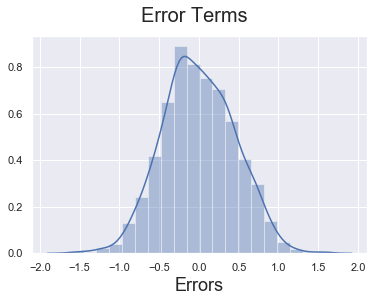

In [43]:
#Residual analysis of train data

lm = LinearRegression()
lm.fit(X_train_final, y_train)
pred = lm.predict(X_train_final)

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [44]:
# R Squared on training data
r2_score(y_train, pred)

0.7121696399723657

In [45]:
# R Squared on test data
X_test_final = X_test[X_train_final.columns]
pred = lm.predict(X_test_final)
r2_score(y_test, pred)

0.6639444670773949

Text(0,0.5,'y_pred')

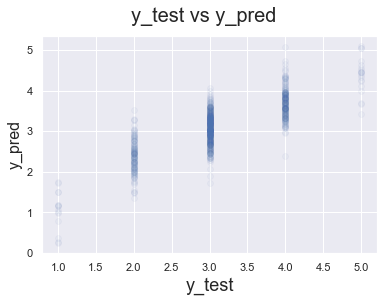

In [46]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test, pred, alpha=0.04)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

# Random Forest

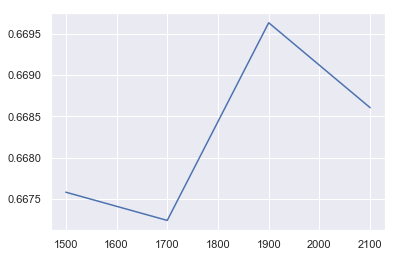

In [47]:
# Observing the effects of n_estimators
clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [x for x in range(1500, 2200, 200)],
}

grid_search = GridSearchCV(clf, param_grid, cv=3, iid=False, return_train_score=False)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

temp = results.sort_values('param_n_estimators')
x = temp.param_n_estimators
y = temp.mean_test_score
plt.plot(x, y)

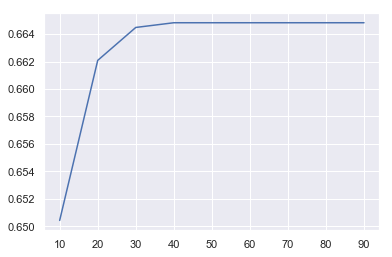

In [48]:
# Observing the effects of max_depth
clf = RandomForestClassifier(n_estimators=100, random_state=42)
param_grid = {
    'max_depth': [x for x in range(10, 100, 10)],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, iid=False, return_train_score=False)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

temp = results.sort_values('param_max_depth')
x = temp.param_max_depth
y = temp.mean_test_score
plt.plot(x, y)

### First Iteration

In [49]:
clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [1900],
    'max_depth': [30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto']
}

rand_search = RandomizedSearchCV(clf, param_grid, 5, cv=3, iid=False, return_train_score=True, random_state=42, verbose=2)
rand_search.fit(X_train, y_train)

pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=1900, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1900, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, total=   7.9s
[CV] n_estimators=1900, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  n_estimators=1900, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, total=   8.5s
[CV] n_estimators=1900, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30 
[CV]  n_estimators=1900, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, total=   7.4s
[CV] n_estimators=1900, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30 
[CV]  n_estimators=1900, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30, total=  10.9s
[CV] n_estimators=1900, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30 
[CV]  n_estimators=1900, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30, total=  10.7s
[CV] n_estimators=1900, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30 
[CV]  n_estimators=1900, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30, total=  10.2s
[CV] n_estimators=1900, min_samples_split=1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.5min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,8.945688,0.051390,0.513495,0.030765,1900,2,1,auto,30,"{'n_estimators': 1900, 'min_samples_split': 2,...",0.667692,0.680041,0.659114,0.668949,0.008589,1,1.000000,1.000000,1.000000,1.000000,0.000000
1,9.320659,0.348351,1.373341,0.089943,1900,5,1,auto,30,"{'n_estimators': 1900, 'min_samples_split': 5,...",0.670769,0.677984,0.651905,0.666886,0.010995,2,0.998971,0.999486,1.000000,0.999486,0.000420
2,8.471843,0.448558,0.476499,0.057531,1900,10,2,auto,30,"{'n_estimators': 1900, 'min_samples_split': 10...",0.663590,0.676955,0.648816,0.663120,0.011493,3,0.963459,0.966084,0.965074,0.964872,0.001081
0,7.610509,0.454611,0.432681,0.009613,1900,5,4,auto,30,"{'n_estimators': 1900, 'min_samples_split': 5,...",0.654359,0.666667,0.647786,0.656270,0.007826,4,0.945445,0.940904,0.944016,0.943455,0.001896
4,8.331166,0.731320,0.452835,0.020617,1900,10,4,auto,30,"{'n_estimators': 1900, 'min_samples_split': 10...",0.657436,0.662551,0.645726,0.655238,0.007043,5,0.927432,0.926002,0.928608,0.927347,0.001066


We can observe that lower value of min_sample_leaf gives better test score.
While sample split of 2 gives best result.

### Second Iteration

In [50]:
clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [1900],
    'min_samples_leaf': [1, 5, 7],
    'min_samples_split': [2],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(clf, param_grid, cv=3, iid=False, return_train_score=False)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.334665,0.549930,0.686001,0.022628,sqrt,1,2,1900,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.668718,0.681070,0.659114,0.669634,0.008987,1
1,7.172335,0.309218,0.500498,0.029055,sqrt,5,2,1900,"{'max_features': 'sqrt', 'min_samples_leaf': 5...",0.655385,0.662551,0.648816,0.655584,0.005609,2
2,6.446830,0.154732,0.531170,0.002096,sqrt,7,2,1900,"{'max_features': 'sqrt', 'min_samples_leaf': 7...",0.654359,0.657407,0.636457,0.649408,0.009242,3


### Results from base estimator

In [51]:
# base estimator (Without Optimization)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.80      0.53      0.64        15
           2       0.53      0.50      0.52       130
           3       0.65      0.78      0.71       373
           4       0.65      0.48      0.55       192
           5       0.80      0.20      0.32        20

   micro avg       0.63      0.63      0.63       730
   macro avg       0.69      0.50      0.55       730
weighted avg       0.63      0.63      0.62       730



C:\Users\Aakash\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Results from best estimator by Grid Search

In [52]:
# grid search best estimator
clf = grid_search.best_estimator_
print("Current Classifier:")
print(clf)
print('\n\n')

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print('Classification Report:')
print(classification_report(y_test,pred))
print('\n\n')

# Printing confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_test,pred))

Current Classifier:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1900, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)



Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.40      0.57        15
           2       0.74      0.49      0.59       130
           3       0.69      0.90      0.78       373
           4       0.73      0.57      0.64       192
           5       0.83      0.25      0.38        20

   micro avg       0.71      0.71      0.71       730
   macro avg       0.80      0.52      0.59       730
weighted avg       0.72      0.71      0.70       730




Confusion Matrix
[[  6   9   0   0   0]
 [  0  64 

##### Micro Avg increased by around 11% (to 72%) by optimization

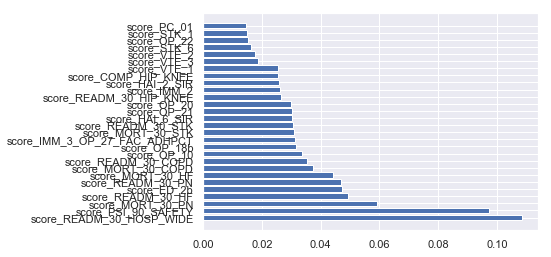

In [53]:
# Feature importance w.r.t random forest model

temp = pd.DataFrame(clf.feature_importances_, X_train.columns).sort_values(0, ascending=False)
plt.barh(temp.index, temp[0])
plt.show()

In [54]:
print(f"According to our random forest model the top 5 most important features are:")
print([x for x in temp.index[:5]])

According to our random forest model the top 5 most important features are:
['score_READM_30_HOSP_WIDE', 'score_PSI_90_SAFETY', 'score_MORT_30_PN', 'score_READM_30_HF', 'score_ED_2b']


## Factor Analysis and Clustering 

In [80]:
# Calculating scores for each measure group

safety_cols = ['score_HAI_1_SIR','score_HAI_2_SIR', 'score_HAI_3_SIR','score_HAI_4_SIR', 'score_HAI_5_SIR', 'score_HAI_6_SIR', 'score_COMP_HIP_KNEE', 'score_PSI_90_SAFETY']
patient_cols = ['H_CLEAN_LINEAR_SCORE','H_COMP_1_LINEAR_SCORE', 'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE','H_COMP_4_LINEAR_SCORE','H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE', 'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE']
timely_cols = ['score_ED_1b', 'score_ED_2b', 'score_OP_18b', 'score_OP_20','score_OP_21','score_OP_3b', 'score_OP_5']
effect_cols = ['CAC_3','IMM_2','IMM_3_OP_27_FAC_ADHPCT','OP_4','OP_22','OP_23','PC_01','STK_1','STK_4','STK_6','STK_8','VTE_1','VTE_2','VTE_3','VTE_5','VTE_6']
effect_cols = ['score_' + x for x in effect_cols]
imaging_cols = ['score_OP_8','score_OP_10','score_OP_11','score_OP_13','score_OP_14']

readmissions_gr = master_df[[x for x in master_df if 'READM' in x]]
mortality_gr = master_df[[x for x in master_df if 'MORT' in x]]
safety_gr = master_df[[x for x in master_df if x in safety_cols]]
patient_exp_gr = master_df[[x for x in master_df if x in patient_cols]]
timely_gr = master_df[[x for x in master_df if x in timely_cols]]
effective_gr = master_df[[x for x in master_df if x in effect_cols]]
imaging_gr = master_df[[x for x in master_df if x in imaging_cols]]

def get_group_score(group):
    if group.shape[1] == 1:
        return group
    
    f=FactorAnalyzer(n_factors=group.shape[1],rotation=None, method='ML')
    re=f.fit(group)
    rweight=re.get_communalities()
    B_1 = np.transpose(np.matrix(rweight))

    for i in range(0, group.shape[1]):
        B_1[i]=B_1[i]/B_1.sum()

    A = group.values
    score_array = pd.DataFrame(A*B_1)
    
    return score_array

readmissions_gr_score = get_group_score(readmissions_gr)*0.22
mortality_gr_score = get_group_score(mortality_gr)*0.22
safety_gr_score = get_group_score(safety_gr)*0.22
# patient_exp_gr_score = get_group_score(patient_exp_gr)
timely_gr_score = get_group_score(timely_gr)*0.04
effective_gr_score = get_group_score(effective_gr)*0.04
imaging_gr_score = get_group_score(imaging_gr)*0.04

md1 = pd.concat([master_df[['provider_id']].reset_index(drop=True), readmissions_gr_score.reset_index(drop=True),
mortality_gr_score.reset_index(drop=True),
safety_gr_score.reset_index(drop=True),
timely_gr_score.reset_index(drop=True),
effective_gr_score.reset_index(drop=True),
imaging_gr_score.reset_index(drop=True)], axis=1, ignore_index=True)

md1.columns = ['provider_id', 'readmissions_gr_score',
'mortality_gr_score',
'safety_gr_score',
'timely_gr_score',
'effective_gr_score',
'imaging_gr_score']

# Summarizing individual group measures to overall group measure 

md2 = pd.DataFrame(scale(md1.drop('provider_id', axis=1).sum(axis=1))*-1)

In [81]:
#Calculating the Hopkins statistic
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

#Let's check the Hopkins measure
hopkins(md2)

#the value is high (above 0.5) good chances of clustering

0.9695176451006675

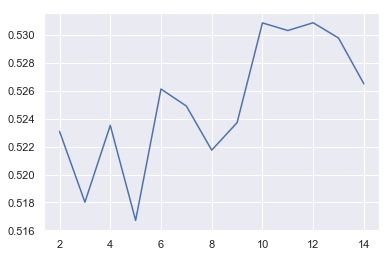

In [82]:
# silhouette score analysis
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(md2)
    sse_.append([k, silhouette_score(md2, kmeans.labels_)])
    
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

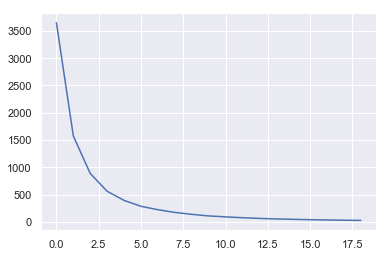

In [83]:
# elbow curve method
ssd = []
for num_clusters in list(range(1,20)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(md2)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [97]:
# proceed with 5 clusters
model_clus = KMeans(n_clusters = 5, random_state = 42)
model_clus.fit(md2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [98]:
md2.index = pd.RangeIndex(len(md2.index))
c_pca_km1 = pd.concat([md2.reset_index(drop=True), pd.Series(model_clus.labels_).reset_index(drop=True)], axis=1)
c_pca_km1.columns = ['Final_group_score', 'ClusterID']
c_pca_km1.head()

,Final_group_score,ClusterID
0,-2.157807,4
1,0.635967,0
2,0.745952,0
3,0.238132,2
4,0.122234,2


In [99]:
cluster2=pd.concat([md1['provider_id'].reset_index(drop=True), c_pca_km1.reset_index(drop=True)],axis=1)
cluster2.columns = ['provider', 'Final_group_score', 'ClusterID']
cluster2.provider = cluster2.provider.astype('O')
cluster2.head()

,provider,Final_group_score,ClusterID
0,10001,-2.157807,4
1,10005,0.635967,0
2,10006,0.745952,0
3,10007,0.238132,2
4,10008,0.122234,2


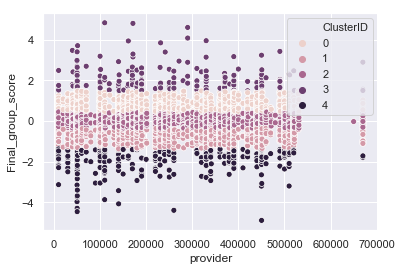

In [100]:
#let us visualise with cluster id
sns.scatterplot(x='provider',y='Final_group_score',hue='ClusterID',legend='full',data=cluster2)

In [107]:
#create division
def clust(x):
    
    if x==3:
        return(5)
    
    elif x==0:
        return(4)
    
    elif x==2:
        return(3)
    
    elif x==1:
        return(2)
    
    elif x==4:
        return(1)
    

cluster2['hospital_rating'] = cluster2['ClusterID'].map(clust)  
cluster2.head()

,provider,Final_group_score,ClusterID,hospital_rating
0,10001,-2.157807,4,1
1,10005,0.635967,0,4
2,10006,0.745952,0,4
3,10007,0.238132,2,3
4,10008,0.122234,2,3


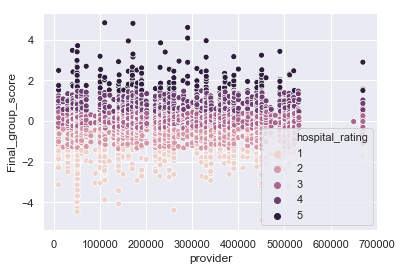

In [109]:
#let us visualise with hospital rating
sns.scatterplot(x='provider',y='Final_group_score',hue='hospital_rating',legend='full',data=cluster2)

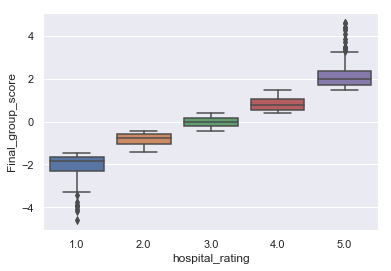

In [89]:
sns.boxplot(x=cluster2['hospital_rating'],y=cluster2['Final_group_score'])

# Recommendations for Evanston Hospital

In [90]:
md1.head()

,provider_id,readmissions_gr_score,mortality_gr_score,safety_gr_score,timely_gr_score,effective_gr_score,imaging_gr_score
0,10001,-4.737895,-3.042264,-0.265721,4.225914,-4.759743,-0.256
1,10005,-4.510551,-3.506251,-0.195345,2.116120,-4.638115,-0.532
2,10006,-4.574434,-3.421710,-0.242057,2.012158,-4.663781,-0.472
3,10007,-4.678972,-3.444542,-0.167279,2.714019,-4.371274,-0.972
4,10008,-4.584920,-2.988234,-0.200381,1.844971,-4.746659,-0.144


### Comparing Evanston scores for each group

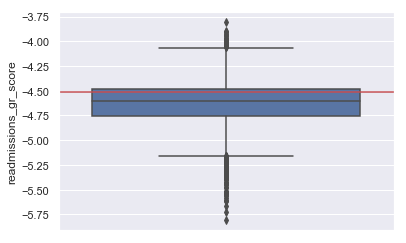

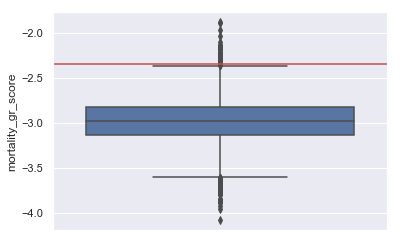

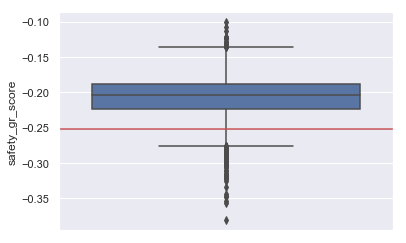

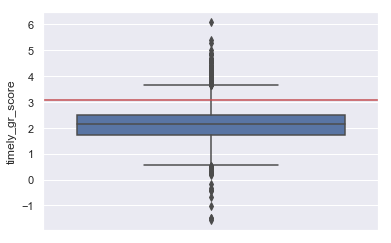

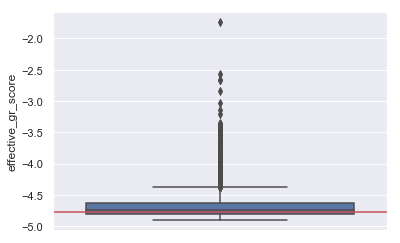

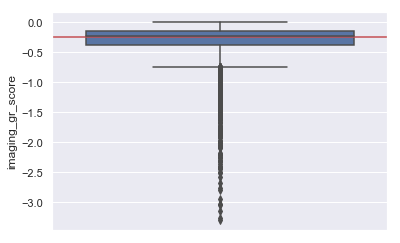

In [110]:
for col in md1.columns[1:]:
    sns.boxplot(y=md1[col])
    plt.axhline(md1[md1.provider_id == 140010][col].values,color='r')
    plt.show()

### Areas of Improvement
If  we analyse the the group score of EVANSTON HOSPITAL in Imaging_group,Timeliness_of_care_group_score,Pat_exp_group_score,Safety group is lesser than the median group score.

##### These groups are the areas of improvement.
Proper action should be taken so that the rating of the EVANSTON HOSPITAL increases to 4 Things  which are to be considered are:

#1. It is required that the Imaging team from the hospital should work very efficiently  so that the proper services are
   delivered patients.It is not advisable that the patients have to wait for long to get their scan done or have to
   visit repeatedly to do  the scan.The Imaging department should be well equipped with latest equipments.
   
#2. In terms of timeliness of care the patients should receive proper treatment and care as early as possible.

#3. The patient should be satified with the service provided by the hospital to give the best rating in survey.This will lead to increase in the patient experience group score.

#4. Safety and concern of the patient is of utmost importance,special care has to be taken while performing any surgery or giving injections to patient so that he or she is not infected by any disease.